
# Gridsearch and multistep, multivariate forecast using stacked lstm




### Load data



In [3]:
# load data
!wget https://github.com/davihdsantos/ncovid-air-paper/blob/main/df_spsp_pred.csv .

--2021-07-14 21:13:31--  https://github.com/davihdsantos/ncovid-air-paper/blob/main/df_spsp_pred.csv
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘df_spsp_pred.csv’

df_spsp_pred.csv        [ <=>                ] 281.52K  --.-KB/s    in 0.03s   

2021-07-14 21:13:31 (8.87 MB/s) - ‘df_spsp_pred.csv’ saved [288272]

--2021-07-14 21:13:31--  http://./
Resolving . (.)... failed: No address associated with hostname.
wget: unable to resolve host address ‘.’
FINISHED --2021-07-14 21:13:31--
Total wall clock time: 0.4s
Downloaded: 1 files, 282K in 0.03s (8.87 MB/s)


## Functions

### Import libs

In [ ]:
from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from numpy import mean
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from keras.callbacks import EarlyStopping
import pandas as pd
import ast
from scipy.signal import savgol_filter
from scipy.signal import medfilt
import datetime
from sklearn.preprocessing import MinMaxScaler
from keras.constraints import maxnorm

### Prepare data for training

In [ ]:
# split a univariate dataset into train/test sets
def split_dataset(data, n_test, n_days):
  # makes dataset multiple of n_days
  data = data[data.shape[0] % n_days:]
  # make test set multiple of n_days
  n_test -= n_test % n_days
  # split into standard weeks
  train, test = data[:-n_test], data[-n_test:]
  # restructure into windows of weekly data
  train = array(split(train, len(train)/n_days))
  test = array(split(test, len(test)/n_days))
  return train, test

# convert history into inputs and outputs
def to_supervised(train, n_input, n_out=7):
  # flatten data
  data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
  X, y = list(), list()
  in_start = 0
  # step over the entire history one time step at a time
  for _ in range(len(data)):
    # define the end of the input sequence
    in_end = in_start + n_input
    out_end = in_end + n_input
    # ensure we have enough data for this instance
    if out_end < len(data):
      # use all features, execept the first
      X.append(data[in_start:in_end, 1:])
      # to predict feature zero
      y.append(data[in_end:out_end, 0])
    # move along one time step
    in_start += 1
  return array(X), array(y)

# grid search configs
def normalize_data(data, type_norm):
  scaler = None
  norm_data = np.array([])
  if not type_norm:
    return data, None

  if type_norm == 'MinMax':
    samples = data.shape[0]
    columns = data.shape[1]
    data_ = data.flatten(order='A')
    data_ = data_.reshape(-1, 1)
    scaler = MinMaxScaler()
    scaler.fit(data_)
    data_ = scaler.fit_transform(data_)
    for i in range(columns):
      a = data_[i*samples:(i+1)*samples]
      if norm_data.shape[0] == 0:
        norm_data = a
      else:
        norm_data = np.hstack((norm_data, a))
  return norm_data, scaler

# grid search configs
def desnormalize_data(data, scaler):
  data_ = data.flatten()
  data_ = scaler.inverse_transform(data_.reshape(-1,1))
  return data_

### Define model configs

In [ ]:
# create a list of configs to try
def model_configs():
  # define scope of configs
  n_input = [7]
  n_nodes = [50]
  n_epochs = [500]
  n_batch = [16]
  dropout = [0.0]
  normalization = [None]
  # create configs
  configs = list()
  for i in n_input:
    for j in n_nodes:
      for k in n_epochs:
        for l in n_batch:
          for o in dropout:
            for p in normalization:
              cfg = [i, j, k, l, o, p]
              configs.append(cfg)
  print('Total configs: %d' % len(configs))
  return configs

### build, train and validate forecast model

In [ ]:
# train the model
def build_model(train, config):
  # unpack config
  n_input, n_nodes, n_epochs, n_batch, dropout, *_ = config
  n_output = n_input
  # prepare data
  train_x, train_y = to_supervised(train, n_input, n_output)
  n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
  train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
  # define model space (encoder - decoder)
  model = define_model_space(n_nodes, n_timesteps, n_features, n_outputs, dropout)
  # early stop
  es = EarlyStopping(monitor='loss', mode='min', verbose=0, patience=100)
  # fit model
  model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch, verbose=0)
  return model

def define_model_space(n_nodes, n_timesteps, n_features, n_outputs, dropout):
  # create model (encoder - decoder)
  model = Sequential()
  model.add(LSTM(n_nodes, activation= 'relu' , input_shape=(n_timesteps, n_features), kernel_constraint=maxnorm(3)))
  model.add(Dropout(dropout))
  model.add(RepeatVector(n_outputs))
  model.add(LSTM(n_nodes, activation= 'relu' , return_sequences=True, kernel_constraint=maxnorm(3)))
  model.add(Dropout(dropout))
  model.add(TimeDistributed(Dense(np.floor(n_nodes/2), activation= 'relu')))
  model.add(TimeDistributed(Dense(1)))
  model.compile(loss= 'mse', optimizer= 'adam')
  return model

# make a forecast
def forecast(model, history, config):
  n_input, *_ = config
  # flatten data
  data = array(history)
  data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
  # retrieve last observations for input data
  input_x = data[-n_input:, 1:]
  # reshape into [1, n_input, 1]
  input_x = input_x.reshape((1, input_x.shape[0], input_x.shape[1]))
  # forecast the next week
  yhat = model.predict(input_x, verbose=0)
  # we only want the vector forecast
  yhat = yhat[0]
  return yhat

# evaluate a single model
def evaluate_model(data, n_test, cfg, models, models_test):
  n_input, *_, type_norm = cfg
  if type_norm != None: 
    data_norm, scaler = normalize_data(data, type_norm)
  else:
    data_norm = data
    scaler = None
  train, test = split_dataset(data_norm, n_test, n_input)
  # fit model
  model = build_model(train, cfg)
  all_data = np.vstack((train,test))
  # history is a list of weekly data
  history = [all_data[0]]
  # walk-forward validation over each week
  predictions = list()
  for i in range(1, len(all_data)):
    # predict the week
    yhat_sequence = forecast(model, history, cfg)
    # store the predictions
    predictions.append(yhat_sequence)
    # get real observation and add to history for predicting the next week
    history.append(all_data[i, :])
  # evaluate predictions days for each week
  predictions = array(predictions)

  # 'denormalize' data, if necessary
  if type_norm != None:
    shape = predictions.shape
    predictions = desnormalize_data(predictions, scaler)
    predictions = predictions.reshape(shape[0], shape[1])
    shape = all_data.shape
    all_data = all_data[:, :, 0].flatten()
    all_data = desnormalize_data(all_data, scaler)
    all_data = all_data.reshape(shape[0], shape[1])
    all_data = all_data[1:, :]

  if type_norm == None:
    all_data = all_data[1:, :, 0]

  score, scores, score_test = evaluate_forecasts(all_data, predictions, n_input, n_test)

  # store the 10 best models to plot forecast curve
  if len(models) < 10:
    models.append((score, cfg, model, scaler, score_test))
    models.sort()

  if (len(models) >= 10) & (score < models[-1][0]):
    models[-1] = (score, cfg, model, scaler, score_test)
    models.sort()

  print(cfg, score, score_test)

  return (score, score_test)

# evaluate a single model
def forecast_model(model, data, n_test, cfg):
  n_input, *_, type_norm = cfg
  if type_norm != None: 
    data_norm, scaler = normalize_data(data, type_norm)
  else:
    data_norm = data
    scaler = None
  train, test = split_dataset(data_norm, n_test, n_input)
  # history is a list of weekly data
  history = [x for x in train]
  # walk-forward validation over each week
  predictions = list()
  for i in range(len(test)):
    # predict the week
    yhat_sequence = forecast(model, history, cfg)
    # store the predictions
    predictions.append(yhat_sequence)
    # get real observation and add to history for predicting the next week
    history.append(test[i, :])
  # evaluate predictions days for each week
  predictions = array(predictions)

  # 'denormalize' data, if necessary
  if type_norm != None:
    shape = predictions.shape
    predictions = desnormalize_data(predictions, scaler)
    predictions = predictions.reshape(shape[0], shape[1])
    shape = test.shape
    test = test[:, :, 0].flatten()
    test = desnormalize_data(test, scaler)
    test = test.reshape(shape[0], shape[1])

  if type_norm == None:
    test = test[:, :, 0]

  # returns real data from feature 0 and its forecast
  return test[:,:], predictions

### Evaluate forecast model predictions

In [ ]:
# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted, n_input, n_test):
  scores = list()
  # calculate an RMSE score for each day
  for i in range(actual.shape[1]):
    # calculate mse
    mse = mean_squared_error(actual[:, i], predicted[:, i])
    # calculate rmse
    rmse = sqrt(mse)
    # store
    scores.append(rmse)
  # calculate overall RMSE
  s = 0
  s_test = 0
  for row in range(actual.shape[0]):
    for col in range(actual.shape[1]):
      s += (actual[row, col] - predicted[row, col])**2
      if row > actual.shape[0]-(n_test/n_input):
        s_test += (actual[row, col] - predicted[row, col])**2
  score = sqrt(s / actual.shape[1])
  score_test = sqrt(s_test / actual.shape[1])
  return score, scores, score_test

# summarize scores
def summarize_scores(name, score, scores):
  s_scores = ', '.join(['%.1f' % s for s in scores])
  print('%s: [%.3f] %s' % (name, score, s_scores))

### Run gridsearch and multiple trainings for each config

In [ ]:
# return average of prediction errors for multiple repeats of same config
def repeat_evaluate(data, n_test, config, models, models_test, n_repeats=3):
  # fit and evaluate the model n times
  scores = [evaluate_model(data, n_test, config, models, models_test) for _ in range(n_repeats)]
  # convert config to a key
  key = str(config)
  #result = mean(scores)
  return (key, scores)

# grid search configs
def grid_search(data, n_test, cfg_list, n_repeats, models, scores, models_test):
  # evaluate configs
  for cfg in cfg_list:
    scores.append(repeat_evaluate(data, n_test, cfg, models, models_test, n_repeats))
  # sort configs by error, asc
  scores.sort(key=lambda tup: tup[1])
  return scores

### Plot boxplot of prediction error distribution for each config

In [ ]:
def boxplot_experiments(data, key, n_repeats, max_value, min_value):
  random_dists = key

  fig, ax1 = plt.subplots(figsize=(10, 6))
  fig.canvas.manager.set_window_title('A Boxplot Example')
  fig.subplots_adjust(left=0.075, right=0.95, top=0.9, bottom=0.25)

  bp = ax1.boxplot(data, notch=0, sym='+', vert=1, whis=1.5)
  plt.setp(bp['boxes'], color='black')
  plt.setp(bp['whiskers'], color='black')
  plt.setp(bp['fliers'], color='red', marker='+')

  ax1.yaxis.grid(True, linestyle='-', which='major', color='lightgrey',
                alpha=0.5)

  ax1.set(
      axisbelow=True,  # Hide the grid behind plot objects
      title='Average performance of %d models for each configuration' % n_repeats,
      xlabel='Model configurations',
      ylabel='RMSE - Deaths forecast',
  )

  box_colors = ['darkkhaki', 'royalblue']
  num_boxes = len(data)
  medians = np.empty(num_boxes)
  for i in range(num_boxes):
      box = bp['boxes'][i]
      box_x = []
      box_y = []
      for j in range(5):
          box_x.append(box.get_xdata()[j])
          box_y.append(box.get_ydata()[j])
      box_coords = np.column_stack([box_x, box_y])
      # Alternate between Dark Khaki and Royal Blue
      ax1.add_patch(Polygon(box_coords, facecolor=box_colors[i % 2]))
      # Now draw the median lines back over what we just filled in
      med = bp['medians'][i]
      median_x = []
      median_y = []
      for j in range(2):
          median_x.append(med.get_xdata()[j])
          median_y.append(med.get_ydata()[j])
          ax1.plot(median_x, median_y, 'k')
      medians[i] = median_y[0]
      # Finally, overplot the sample averages, with horizontal alignment
      # in the center of each box
      ax1.plot(np.average(med.get_xdata()), np.average(data[i]),
              color='w', marker='*', markeredgecolor='k')

  # Due to the Y-axis scale being different across samples, it can be
  # hard to compare differences in medians across the samples. Add upper
  # X-axis tick labels with the sample medians to aid in comparison
  # (just use two decimal places of precision)
  pos = np.arange(num_boxes) + 1
  upper_labels = [str(round(s, 2)) for s in medians]
  weights = ['bold', 'semibold']
  for tick, label in zip(range(num_boxes), ax1.get_xticklabels()):
      k = tick % 2
      ax1.text(pos[tick], .95, upper_labels[tick],
              transform=ax1.get_xaxis_transform(),
              horizontalalignment='center', size='x-small',
              weight=weights[k], color=box_colors[k])

  # Set the axes ranges and axes labels
  ax1.set_xlim(0.5, num_boxes + 0.5)
  top = max(max(data))+max_value
  bottom = min(min(data))+min_value
  ax1.set_ylim(bottom, top)
  ax1.set_xticklabels(np.repeat(random_dists, 1),
                      rotation=70, fontsize=8)

  plt.show()

def boxplot_experiments_best(scores_grid, n_best, n_repeats, max_value, min_value):
  # get errors
  scores_list = list()
  scores_list_test = list()
  for key, cfg in scores_grid:
    scores = list()
    scores_test = list()
    for error, error_test  in cfg:
      # erro de ajuste
      scores.append(error)
      # erro de predição
      scores_test.append(error_test)
    scores_list.append((key, scores))
    scores_list_test.append((key, scores_test))

  list_scores_list = list()

  for list_score in [scores_list, scores_list_test]:
    # scores_list contém key da cfg e erros
    scores_array = np.array(list_score, dtype=object)
    scores_dict = dict(zip(scores_array[:,0], scores_array[:,1]))

    # sort configs by mean error
    config_averages = ((sum(scores) / len(scores), scores, s) for s, scores in scores_dict.items())

    score_list = list()
    key_list = list()
    average_list = list()

    for average, scores, config in sorted(config_averages, reverse=False):
      average_list.append(average)
      score_list.append(scores)
      key_list.append(config)

    boxplot_experiments(score_list[:n_best], key_list[:n_best], n_repeats, max_value, min_value)
    list_scores_list.append(score_list)

  return list_scores_list, key_list

# plot best forecast curve for the best models
def plot_predictions(models, data, n_models, n_test, date_, t_average):

  # array com todos os caras ordenados
  for model in models[:n_models]:
    model_ = model[2]
    cfg_array = model[1]
    cfg_ = str(cfg_array)
    n_input = cfg_array[0]

    # forecast_model
    test, predictions = forecast_model(model_, data, data.shape[0]-n_input, cfg_array)
    predictions = predictions.flatten()
    predictions = predictions.reshape(-1,1)
    test = test.flatten()
    test = test.reshape(-1,1)

    # copy this variable beacuse python ResidentSleeper
    date = date_.copy()

    date = date[:test.shape[0]]

    x_tick = list()
    # 10 values in axis x (9 + the last one)
    n_ticks = np.ceil(date.shape[0]/9)

    for i in range(date.shape[0]):
      if i % n_ticks == 0:
        x_tick.append(date[i])
    x_tick.append(date[-1])

    # calculates the series of accumulated deaths
    predictions_acc = moving_average_to_acc(predictions, t_average)
    test_acc = moving_average_to_acc(test, t_average)

    error_acc = (-test_acc[-1] + predictions_acc[-1]) * 100 / test_acc[-1]

    plt.rcParams["figure.figsize"] = (15,5)
    plt.plot(date, test, label='Real Data')
    plt.plot(date, predictions, label='Predicted')
    plt.axvspan(test.shape[0]-n_test, test.shape[0]-1, color='red', alpha=0.1)
    plt.xlabel("Days")
    plt.ylabel("Biweekly moving average")
    plt.title("Forecast of model (%.2f, %.2f) from config " % (model[0], model[4]) + cfg_)
    plt.legend()
    plt.xticks(x_tick)
    plt.grid()
    plt.show()

    plt.rcParams["figure.figsize"] = (15,5)
    plt.plot(date, test_acc, label='Real Data')
    plt.plot(date, predictions_acc, label='Predicted')
    plt.axvspan(test_acc.shape[0]-n_test, test_acc.shape[0]-1, color='red', alpha=0.1)
    plt.xlabel("Days")
    plt.ylabel("Biweekly moving average")
    plt.title("Accumulated Forecast with error %.2f %% from config " % error_acc + cfg_)
    plt.legend()
    plt.xticks(x_tick)
    plt.grid()
    plt.show()

def moving_average_to_acc(data, t_average):
  # transform to dataframe
  df_data = pd.DataFrame(data=data[:,0], columns=['deaths'])
  # copy this variable beacuse python ResidentSleeper
  df_data = df_data.copy()

  flag = False

  for i in range(0, data.shape[0]-1):
    sum = 0
    if i >= t_average-1:
      for j in range(1,t_average):
        sum = sum + df_data['deaths'][i-j]
      # convert from biweekly moving average to daily deaths
      df_data['deaths'][i] = df_data['deaths'][i+1]*t_average - sum
      # check if theres negative numbers (sometimes this happens if the model is bad)
      if df_data['deaths'][i+1]*t_average < sum:
        flag = True
  # accumulate daily deaths
  df_data["deaths"] = df_data["deaths"].cumsum()
  # shift
  df_data['deaths'] = df_data['deaths'].shift(periods=1)
  # remove nans
  df_data['deaths'] = df_data['deaths'].fillna(0)
  # filter acc data from bad model (avoid weird behavior)
  if flag:
    df_data['deaths'] = savgol_filter(df_data['deaths'].values, 71, 2)
  return df_data['deaths'].values

# plot best acc models
def plot_accumulated(scores_grid, data, n_models, n_test):
  tmp_list = list()
  for cfg, model in scores_grid:
    for x in model:
      tmp_ = np.array(x)
      tmp_ = np.insert(tmp_, 0, cfg)
      tmp_list.append(tmp_)
  tst = np.array(tmp_list)
  tst = sorted(tst, key=lambda tst: tst[1], reverse=False)
  tst = np.array(tst)

  # array com todos os caras ordenados
  for model in tst[:n_models]:
    model_ = model[2]
    cfg_ = model[0]
    cfg_array = ast.literal_eval(cfg_)
    n_input = cfg_array[0]

    test, predictions = forecast_model(model_, data, data.shape[0]-n_input, cfg_array)
    predictions = predictions.flatten()
    test = test.flatten()

    # monta a série de mortes acumuladas da predição
    predictions_acc = moving_average_to_acc(predictions.reshape(-1,1), t_average)
    test_acc = moving_average_to_acc(test.reshape(-1,1), t_average)

    error_acc = (-test_acc[-1] + predictions_acc[-1]) * 100 / test_acc[-1]

    plt.rcParams["figure.figsize"] = (15,5)
    plt.plot(test_acc, label='Real Data')
    plt.plot(predictions_acc, label='Predicted')
    plt.axvspan(test_acc.shape[0]-n_test, test_acc.shape[0], color='red', alpha=0.1)
    plt.xlabel("Days")
    plt.ylabel("Weekly moving average")
    plt.title("Accumulated Forecast of model %.2f from config " % error_acc + cfg_)
    plt.legend()
    plt.grid()
    plt.show()

## Load dataset

In [ ]:
#run online
df = read_csv('df_spsp_pred.csv')

# recebe os dados como um array onde as linhas são os timesteps e as colunas são as features
# a primeira feature é aquela que será predita, as outras são as entradas (com a primeira feature não inclusa).
# se quiser a primeira feature também como entrada, deve repetir o vetor. ex: [df['deaths'].values, df['cases'].values, 'deaths'].values] (mortes e casos para prever mortes)

# D
#data = [df['deaths'].values, df['deaths'].values]
# D + A
#data = [df['deaths'].values, df['deaths'].values, df['aqi'].values]
# D + A + T + H
#data = [df['deaths'].values, df['deaths'].values, df['aqi'].values, df['temperature'].values, df['humidity'].values]
# D + C + A + T + H
data = [df['deaths'].values, df['deaths'].values, df['cases'].values, df['aqi'].values, df['temperature'].values, df['humidity'].values]

data = array(data).T
print(data.shape)

(446, 2)


## Gridsearch

### Define training configs

In [ ]:
# number of weeks for the test dataset
n_weeks = 6

n_test = 7*n_of_weeks
n_repeats = 50

config = model_configs()

Total configs: 1


In [ ]:
config

[[7, 50, 500, 16, 0.0, None]]

### Run simple gridsearch

In [ ]:
# store scores and configs
scores_grid = list()
# store best models to plot
models = list()
models_test = list()

# grid search
grid_search(data, n_test, config, n_repeats, models, scores_grid, models_test)
print('done')
# list top 3 configs
for cfg, error in scores_grid[:3]:
  print(cfg, error)

[7, 50, 500, 16, 0.0, None] 47.67250235165708 9.359500941478405
[7, 50, 500, 16, 0.0, None] 49.40179751442502 7.985579368100869
[7, 50, 500, 16, 0.0, None] 54.42839063422002 10.627492455242228
[7, 50, 500, 16, 0.0, None] 50.11811488327474 9.673834237139701
[7, 50, 500, 16, 0.0, None] 66.43699655853469 18.20611814849913
[7, 50, 500, 16, 0.0, None] 48.28900119818953 8.771371083450623
[7, 50, 500, 16, 0.0, None] 49.33853726820065 9.521100753489876
[7, 50, 500, 16, 0.0, None] 52.42480431457875 10.433972887743574
[7, 50, 500, 16, 0.0, None] 52.79422760823384 13.450169467921969
[7, 50, 500, 16, 0.0, None] 53.5359610084077 10.755491051948985
[7, 50, 500, 16, 0.0, None] 53.749411788205876 8.869854792252493
[7, 50, 500, 16, 0.0, None] 48.31636566843837 9.891398660252992
[7, 50, 500, 16, 0.0, None] 52.0805392479703 9.321544786385454
[7, 50, 500, 16, 0.0, None] 51.36340111995481 10.489741082064418
[7, 50, 500, 16, 0.0, None] 48.65027861559479 8.437038380746149
[7, 50, 500, 16, 0.0, None] 49.70574

## Visualization

### Plot boxplot and forecast from best models

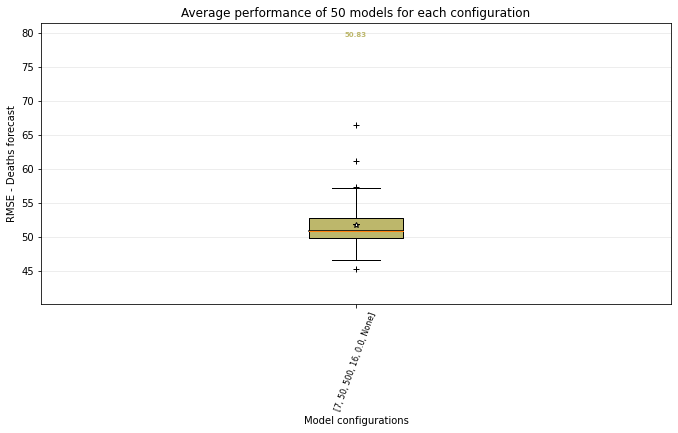

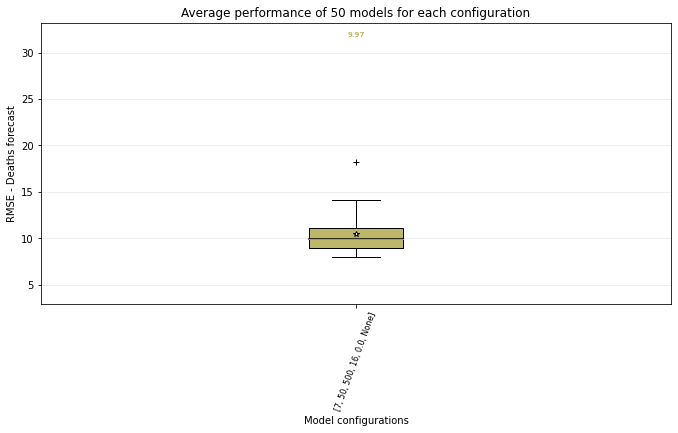

In [ ]:
# plot top configs
score_list, key_list = boxplot_experiments_best(scores_grid, 10, n_repeats, 15, -5)

In [ ]:
models

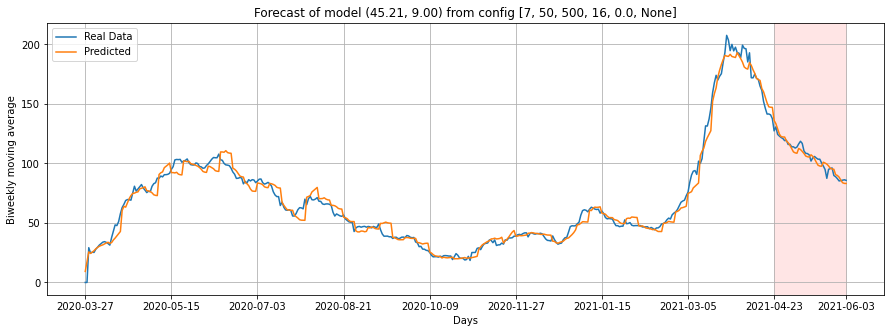

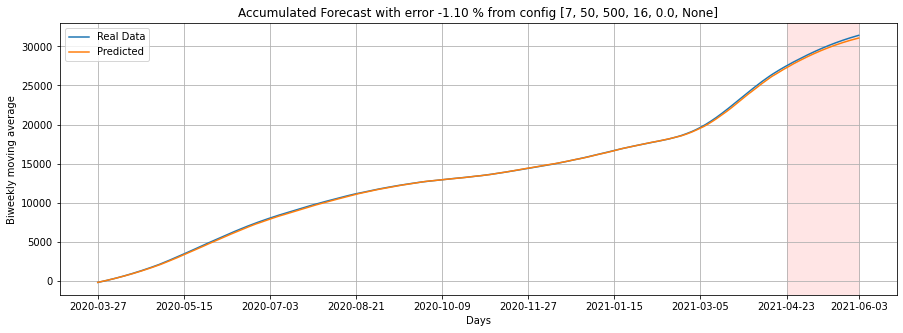

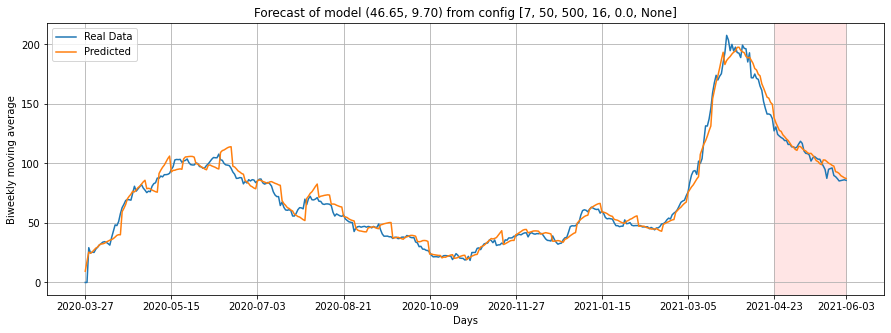

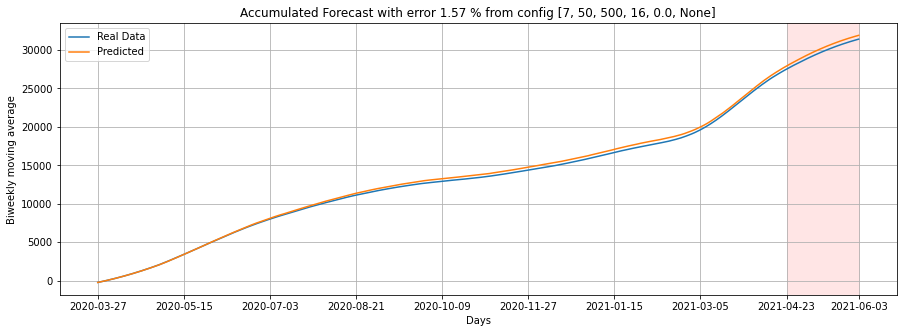

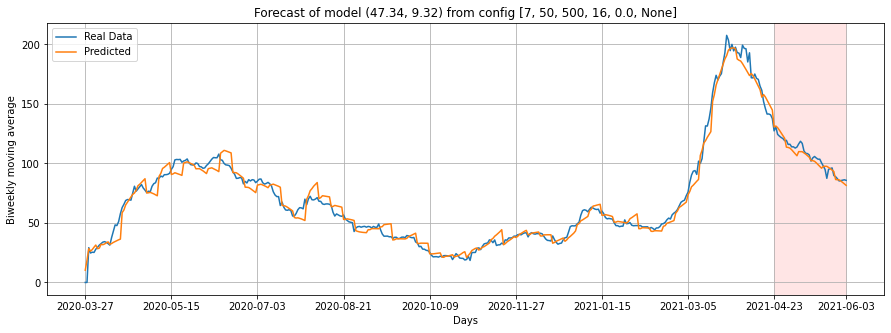

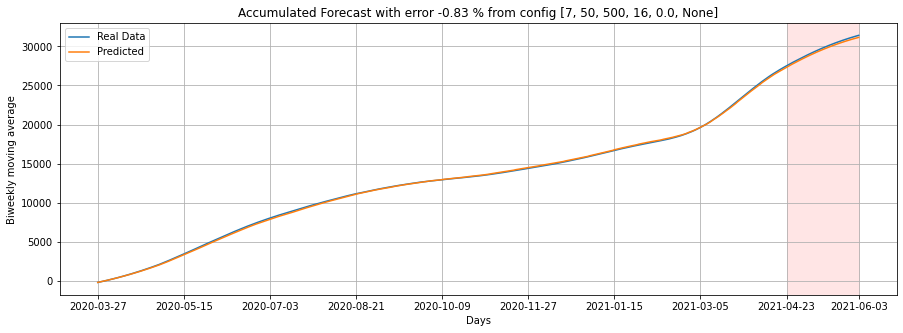

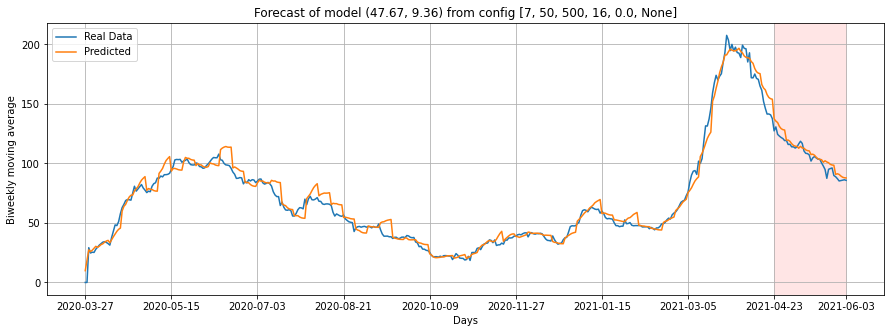

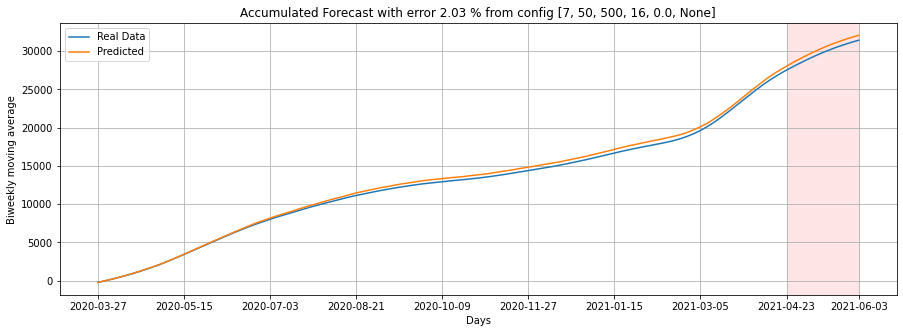

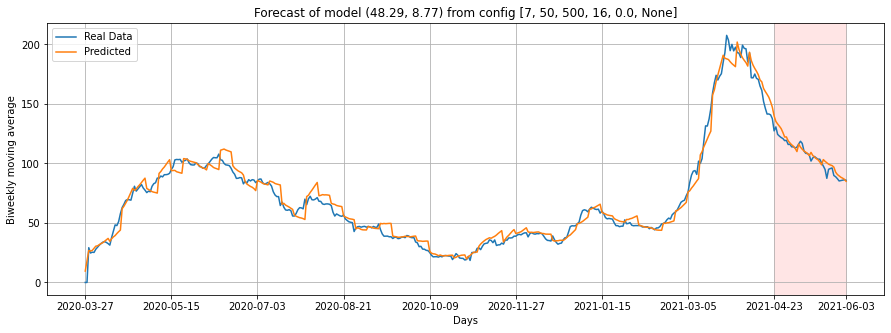

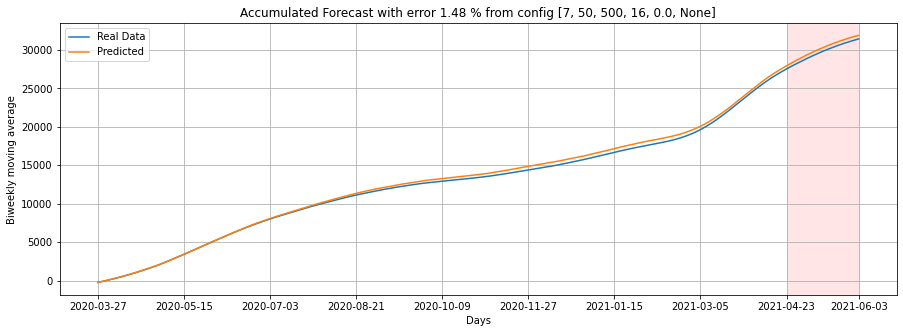

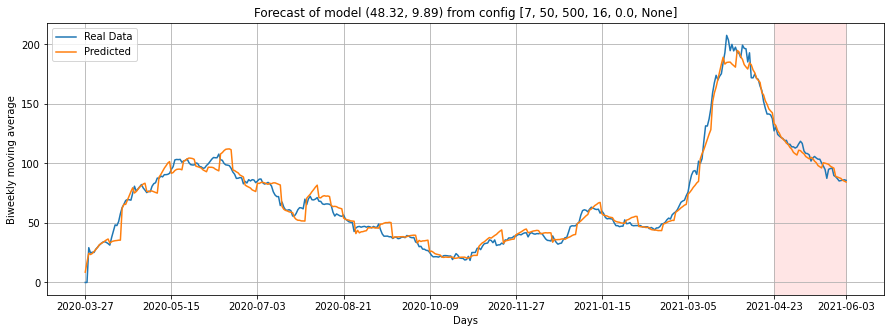

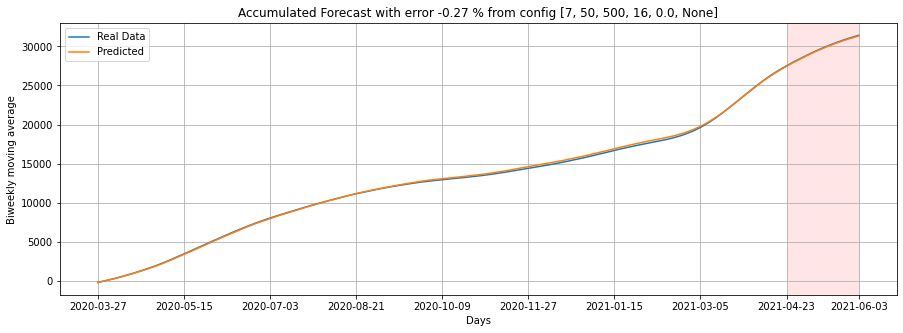

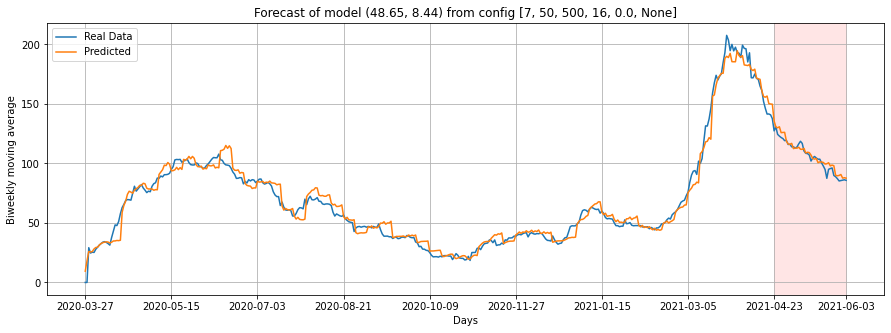

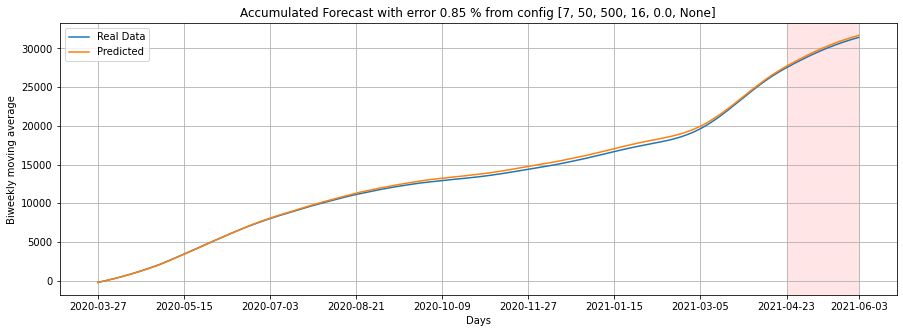

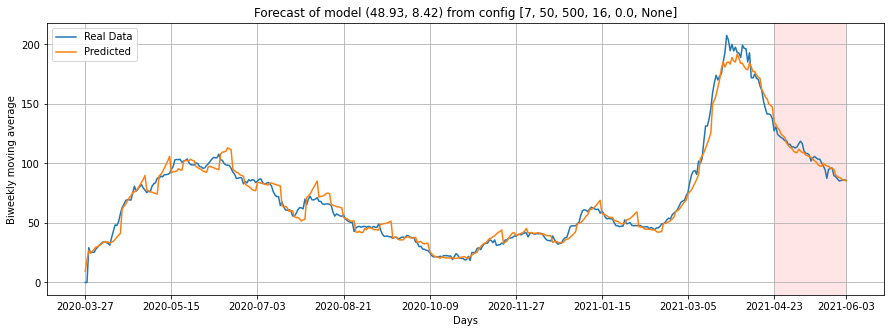

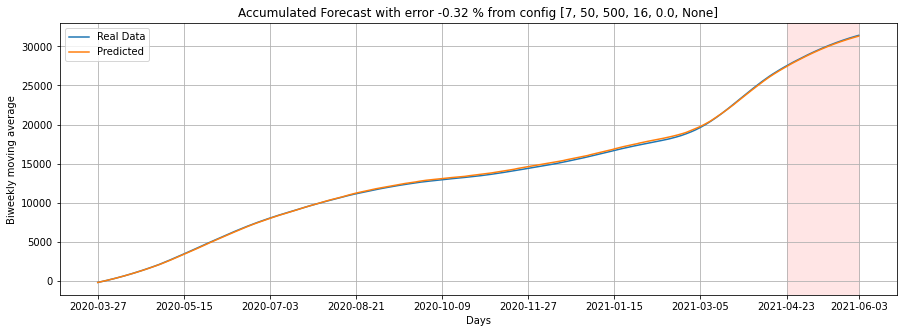

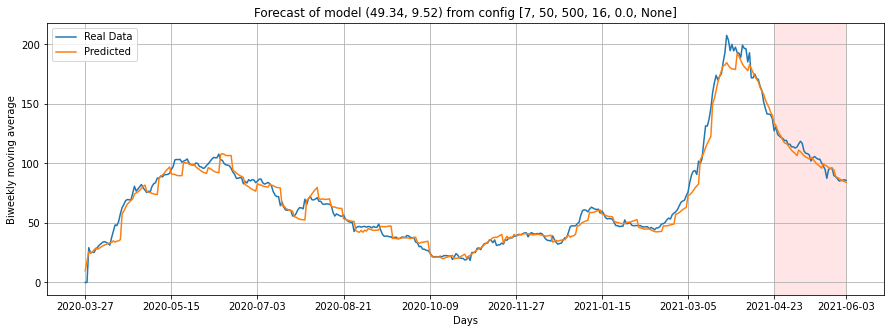

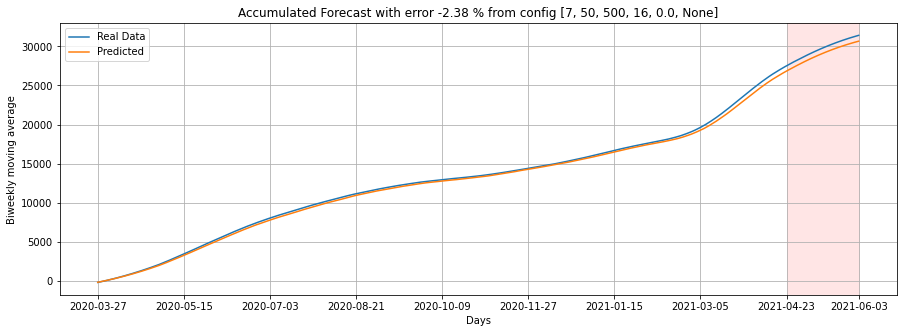

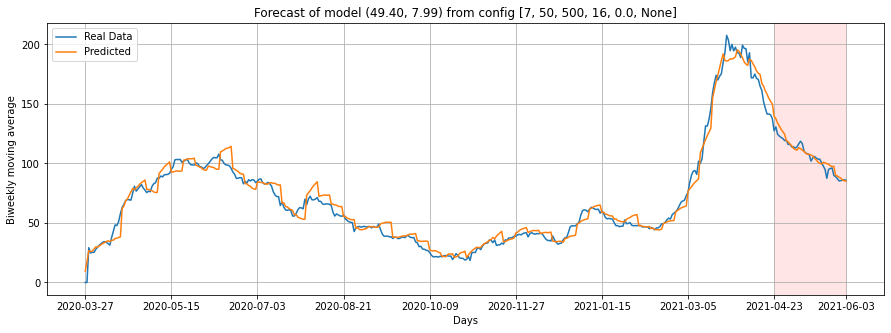

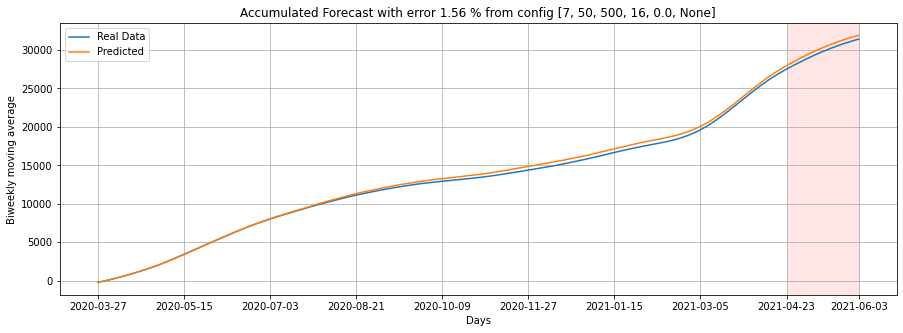

In [ ]:
plot_predictions(models, data, 10, n_test, df['date'].values, 14)

## Storing data from experiments

### Store the best configs and their average RMSE

In [ ]:
today = datetime.date.today()

n = 10

exp_name = 'mortes_mortes_final_' + str(today)

# store average RMSE for the whole dataset (fit + forecast)
dframe1 = pd.DataFrame(score_list[0], key_list)

filename = exp_name + '.csv'
dframe1.to_csv(filename)

# store average RMSE for the test dataset (forecast)
dframe2 = pd.DataFrame(score_list[1], key_list)

filename = exp_name + '_test' + '.csv'
dframe2.to_csv(filename)

In [ ]:
# store 10 best models
errors_list = list()
i = 0
for exp in models[:10]:
  model = exp[2]
  model.save(exp_name + '_' + str(i) + '.h5')
  errors_list.append([exp[0], exp[4]])
  i = i + 1

In [ ]:
# store forecast error (the error)
dframe3 = pd.DataFrame(errors_list)

filename = exp_name + '_saved_models_errors' + '.csv'
dframe3.to_csv(filename)

In [ ]:
ls

df_brasil_pred.csv
df_rj_pred.csv
df_rjrj_pred.csv
df_sp_pred.csv
df_spsp_pred.csv
drive/
mortes_mortes_final_2021-07-13_0.h5
mortes_mortes_final_2021-07-13_1.h5
mortes_mortes_final_2021-07-13_2.h5
mortes_mortes_final_2021-07-13_3.h5
mortes_mortes_final_2021-07-13_4.h5
mortes_mortes_final_2021-07-13_5.h5
mortes_mortes_final_2021-07-13_6.h5
mortes_mortes_final_2021-07-13_7.h5
mortes_mortes_final_2021-07-13_8.h5
mortes_mortes_final_2021-07-13_9.h5
mortes_mortes_final_2021-07-13.csv
mortes_mortes_final_2021-07-13_saved_models_errors.csv
mortes_mortes_final_2021-07-13_test.csv
sample_data/


### **SAVING FILES**

In [ ]:
#cp *_multivariado.csv /home/davi/Documents/dados_treino

cp: '2021-06-09_multivariado.csv' and '/home/davi/Documents/dados_treino/2021-06-09_multivariado.csv' are the same file


In [ ]:
cp mortes* /content/drive/My\ Drive/Colab\ Notebooks/artigo_aqi/experimentos/

## Plot training metrics (error, accuracy) (**not working**)

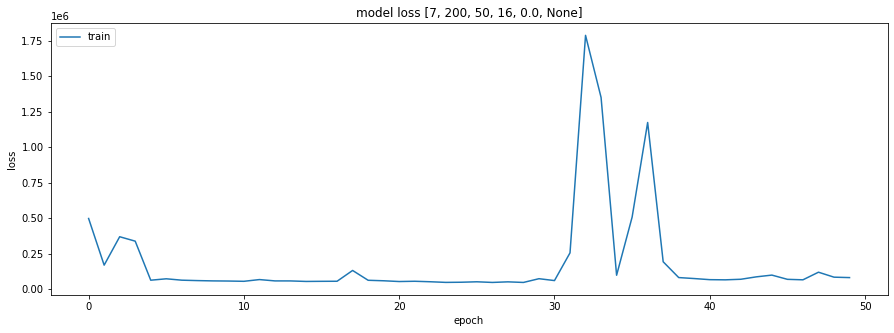

81712.40625 545.2945594010561


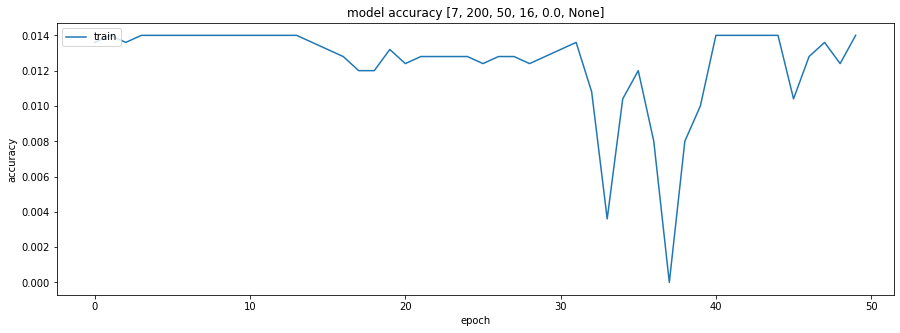

0.014005602337419987


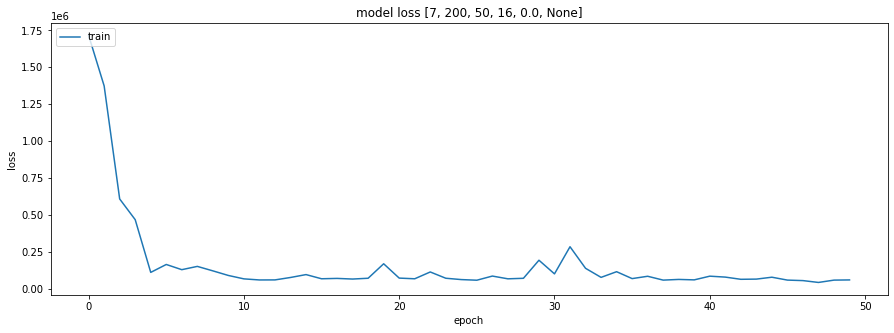

58448.875 593.2899539751254


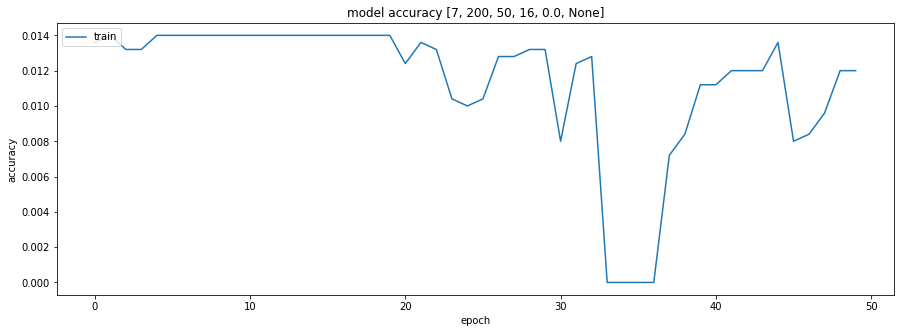

0.012004802003502846


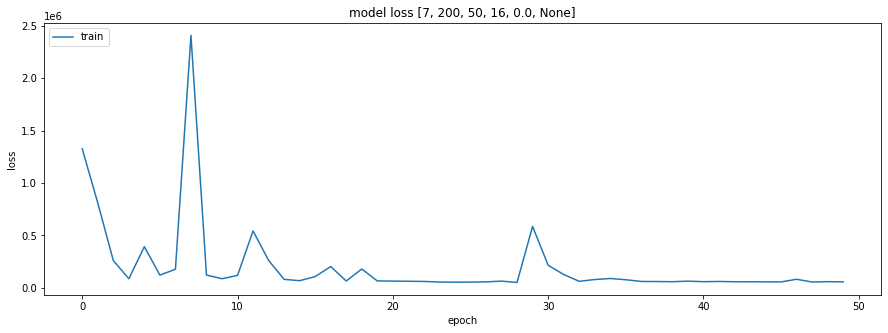

57123.69140625 701.8678012578573


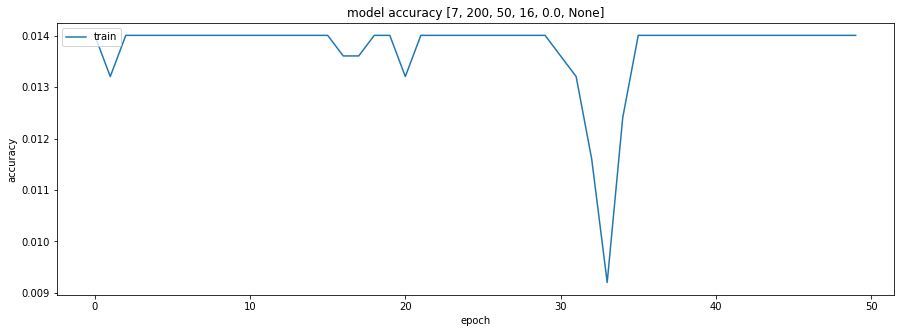

0.014005602337419987


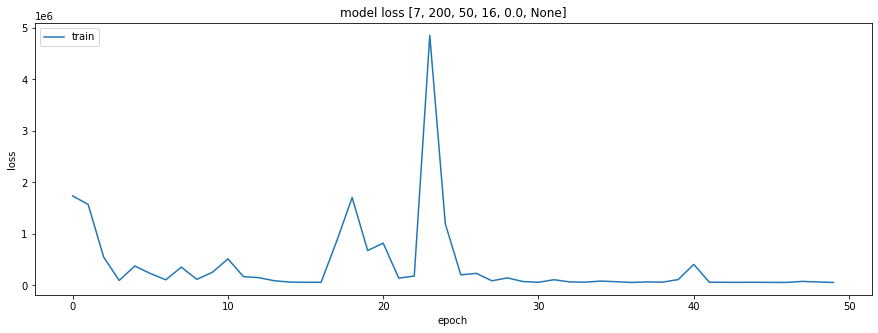

58154.55078125 849.8950940350938


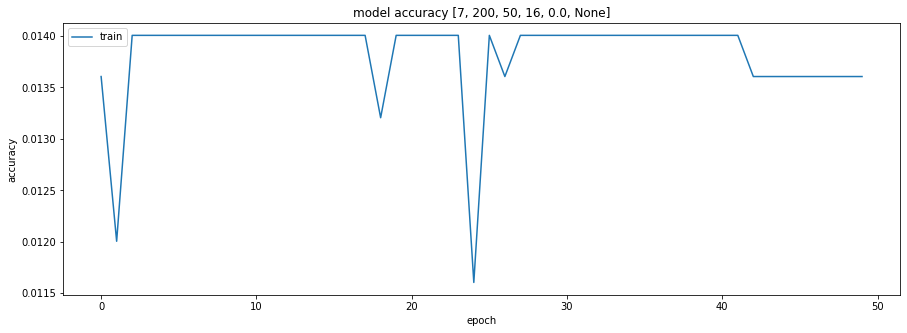

0.013605441898107529


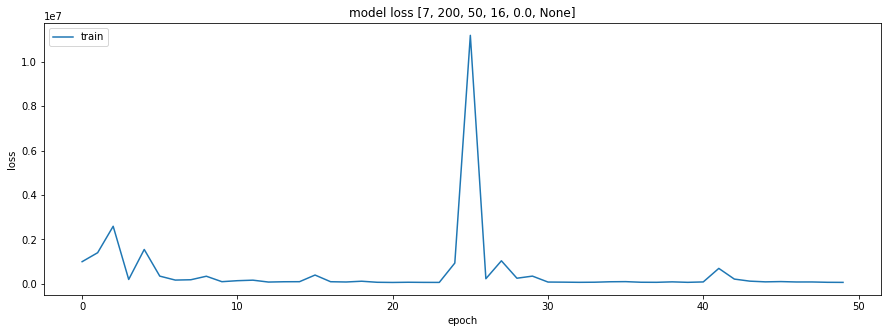

59886.21875 750.229178140822


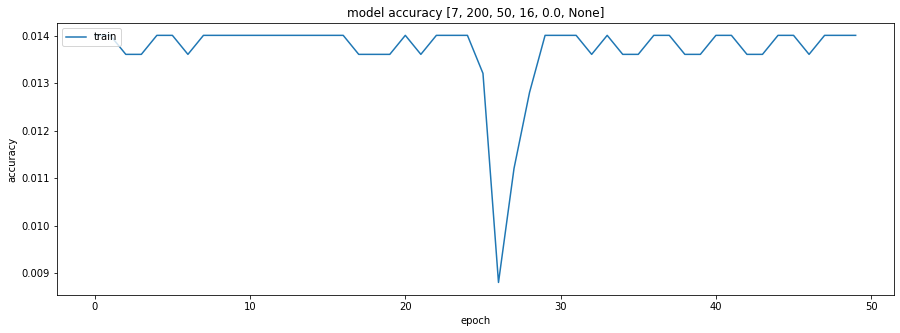

0.014005602337419987


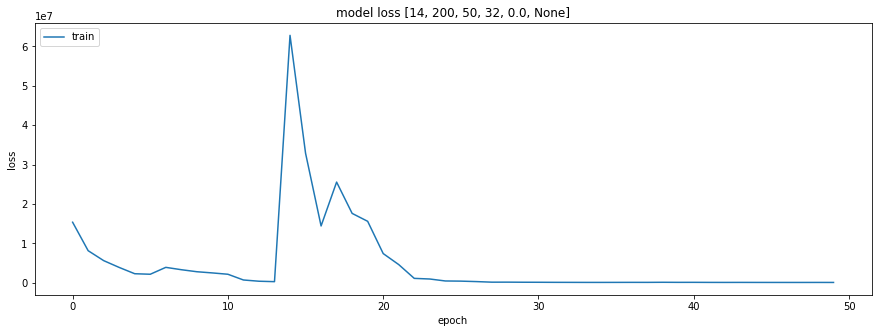

90402.6953125 842.0727446662169


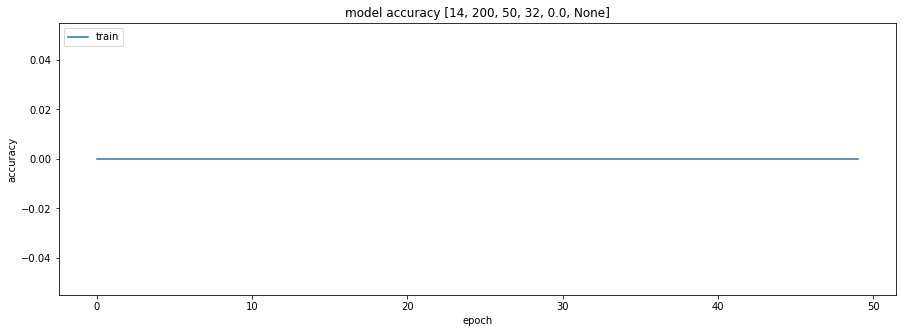

0.0


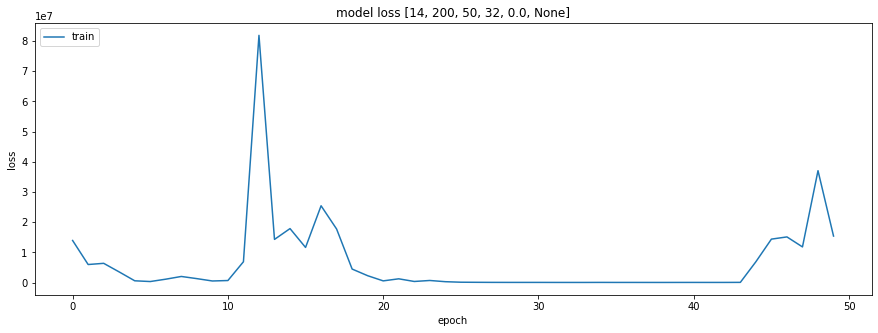

15428521.0 14585.593731581956


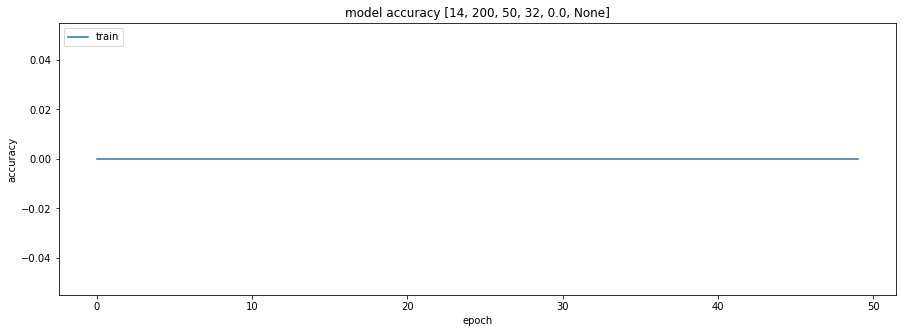

0.0


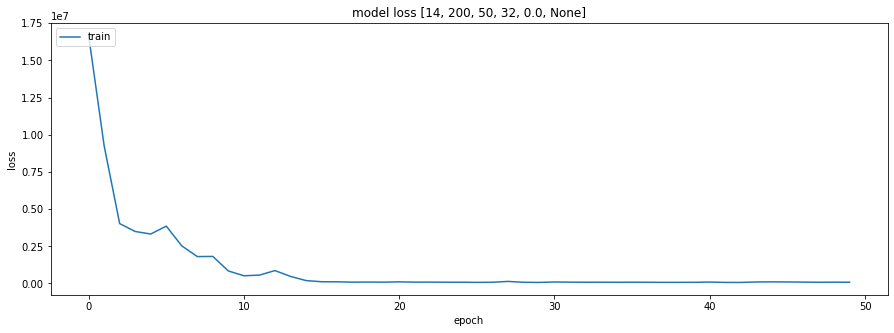

84398.4140625 716.9301511288093


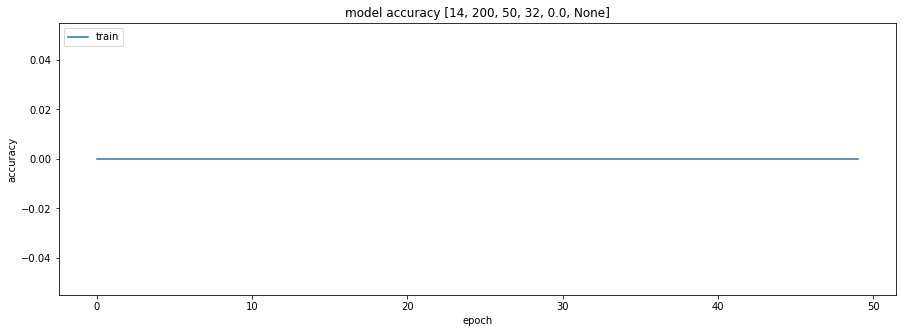

0.0


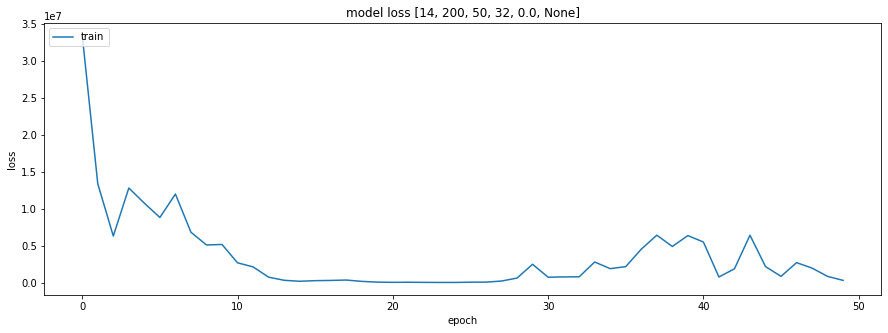

355421.1875 894.6161852594157


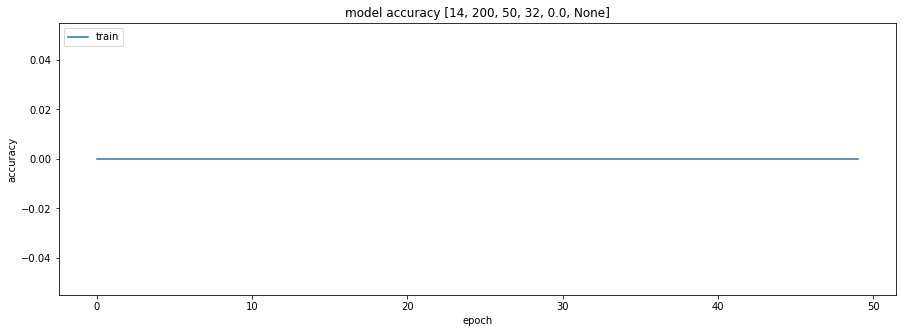

0.0


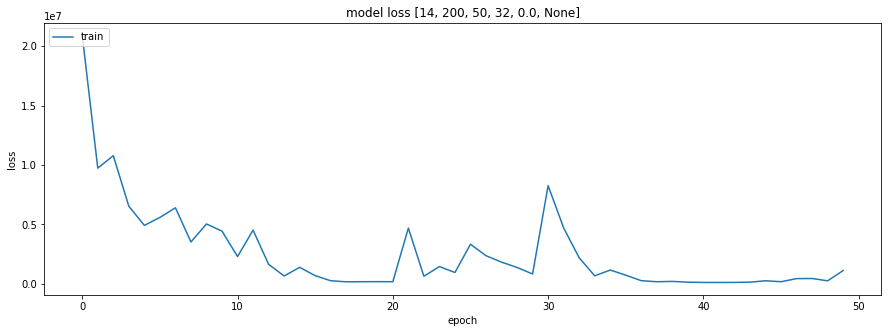

1102980.375 2070.0652015404307


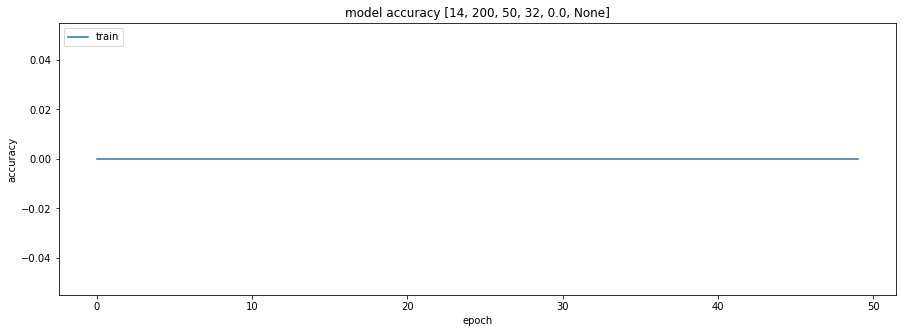

0.0


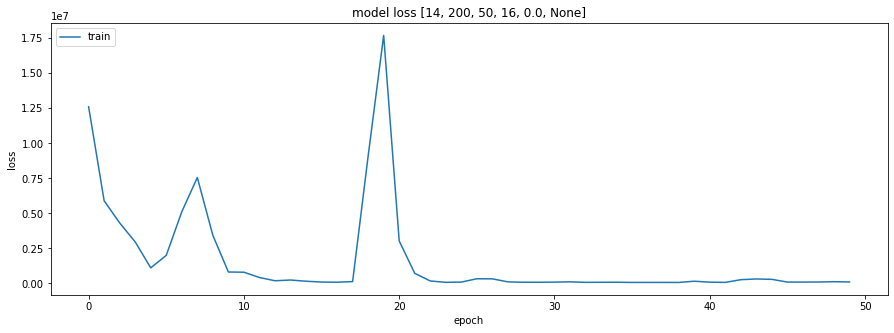

107424.203125 941.880841498938


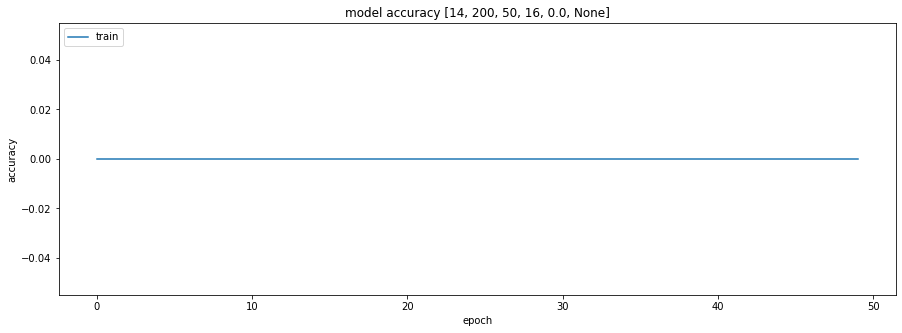

0.0


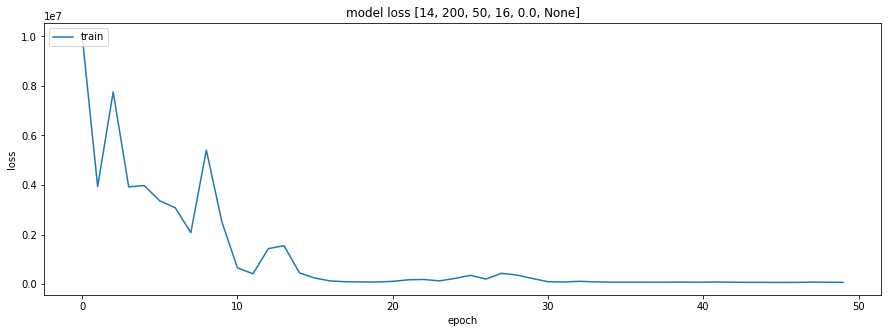

72881.6875 701.0938002517865


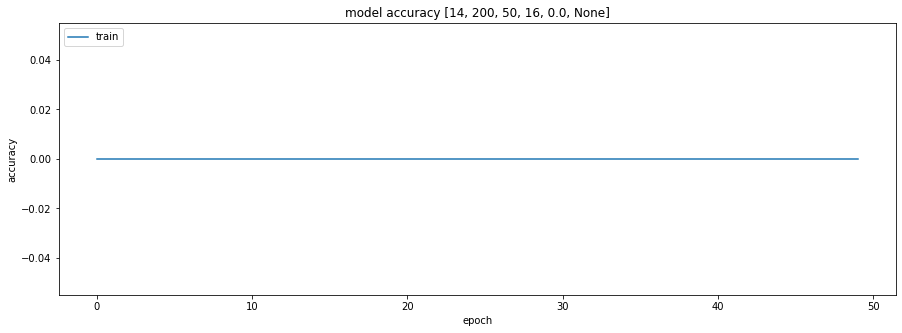

0.0


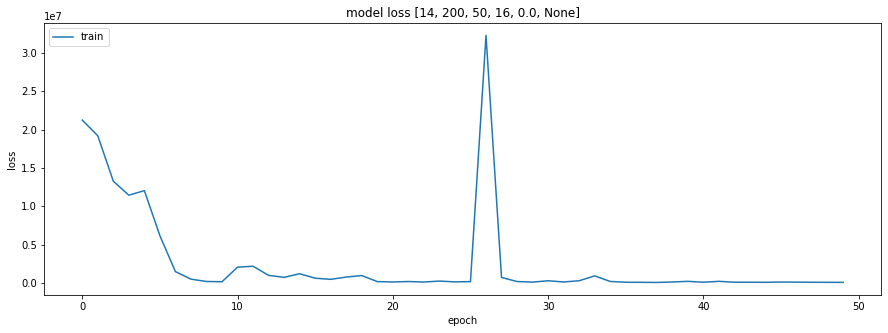

84686.5703125 787.896477964469


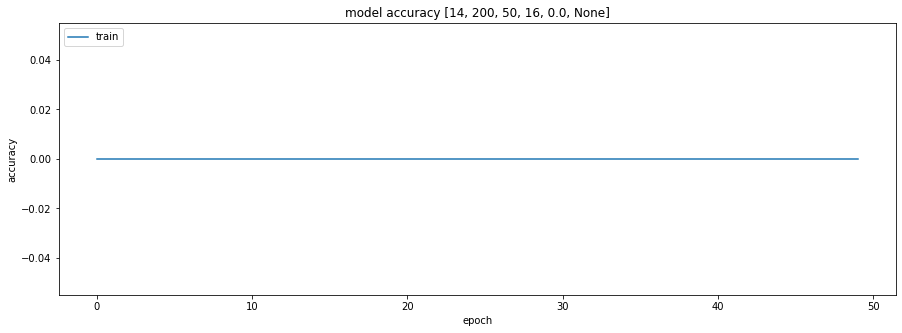

0.0


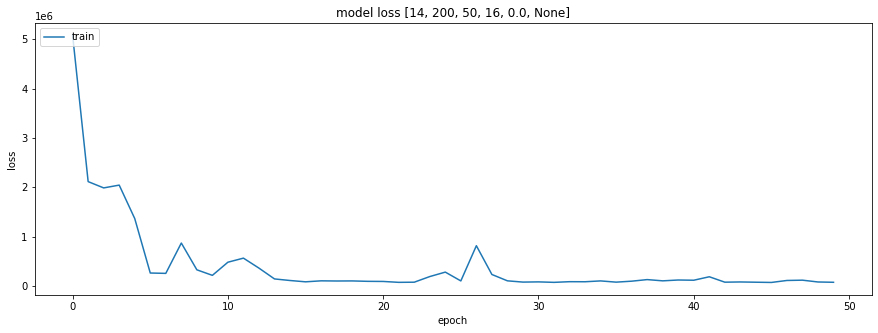

75709.9296875 1111.8303346956404


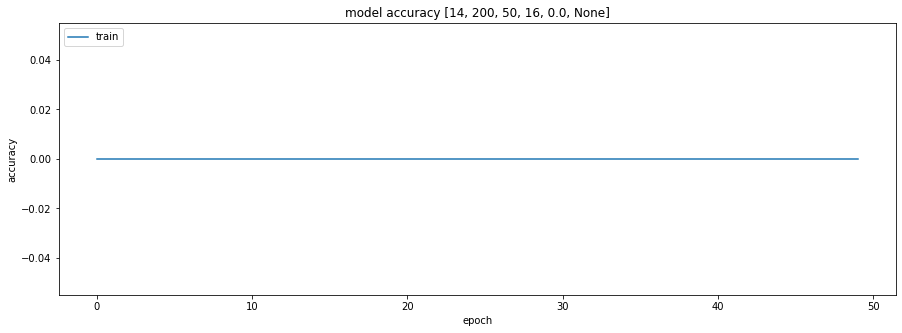

0.0


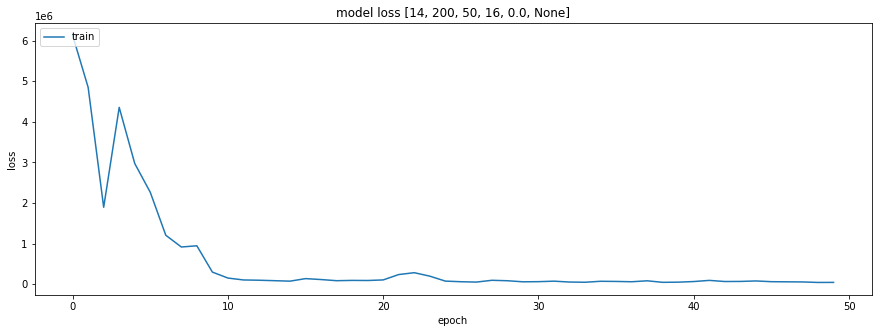

43091.79296875 758.86205723699


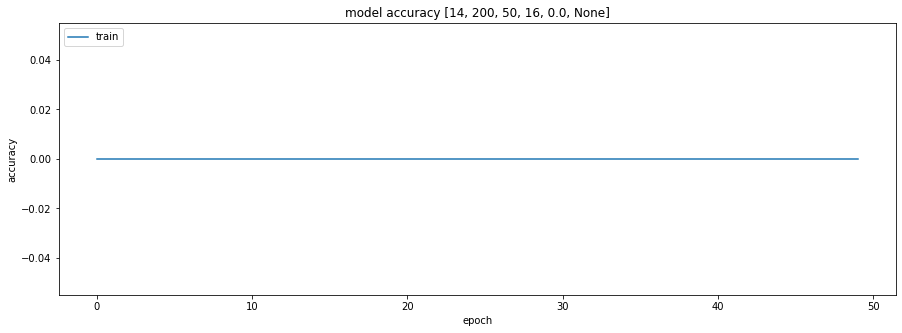

0.0


In [ ]:
for cfg, error in scores_grid[:3]:
  for score, model, history, _ in error:
    #print(history.history.keys())
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.title('model loss '+ cfg)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    print(history.history['loss'][-1], score)
    plt.plot(history.history['accuracy'])
    plt.title('model accuracy '+ cfg)
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    print(history.history['accuracy'][-1])

In [ ]:
for cfg, error in scores_grid[:3]:
  for score, model, history, _ in error:
    print(score)

774.9906217717001
953.6117636326386
